# An image classifier for a store

In [1]:
import numpy as np
import pandas as pd
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


Lets load the data and see the available information

In [2]:
data, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [3]:
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='/home/milton/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      aut

Preparing to train network

In [4]:
train, test = data['train'], data['test']

In [5]:
class_names = metadata.features['label'].names
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# normalize data
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255 #Aqui lo pasa de 0-255 a 0-1
    return images, labels

# Normalize train and test
train = train.map(normalize)
test = test.map(normalize)

# Cache data to memory for improving speed
train = train.cache()
test = test.cache()

In [8]:
#Show training data
image, label = next(iter(train.take(1)))
image = image.numpy().reshape((28,28)) 
print(class_names[label])

Pullover


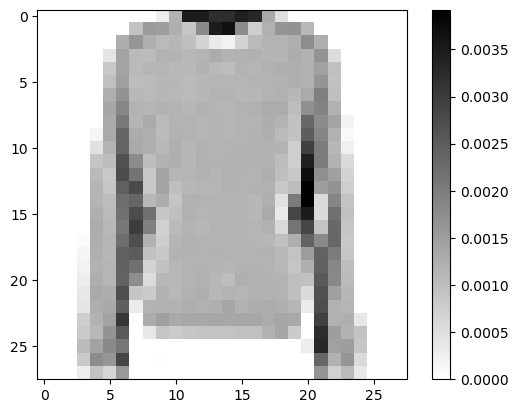

In [9]:
for image, label in train.take(1):
    break
image = image.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

#Dibujar dibujar
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

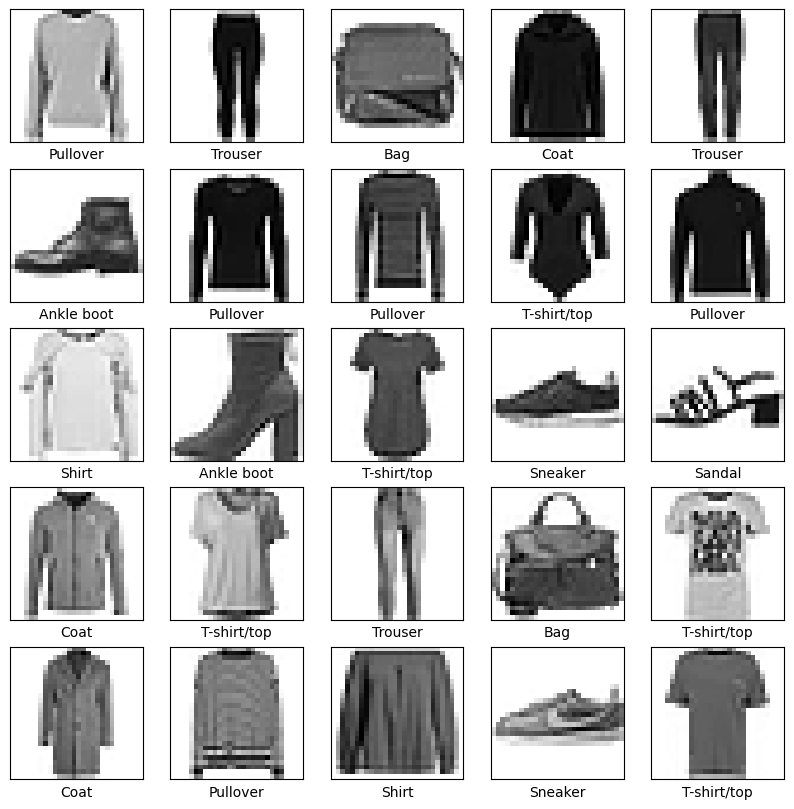

In [10]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

In [11]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)), 
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) 
])

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [14]:
train_count = metadata.splits["train"].num_examples
test_count = metadata.splits["test"].num_examples
train_count, test_count

(60000, 10000)

In [15]:
batch_size = 32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
train = train.repeat().shuffle(train_count).batch(batch_size)
test = test.batch(batch_size)

In [16]:
import math

#Entrenar
history = model.fit(train, epochs=5, steps_per_epoch= math.ceil(train_count/batch_size))

Epoch 1/5
1875/1875 [==============================] - 6s 2ms/step - loss: 1.0277 - accuracy: 0.6270
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6375 - accuracy: 0.7675
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5652 - accuracy: 0.7954
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5333 - accuracy: 0.8086
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5002 - accuracy: 0.8217


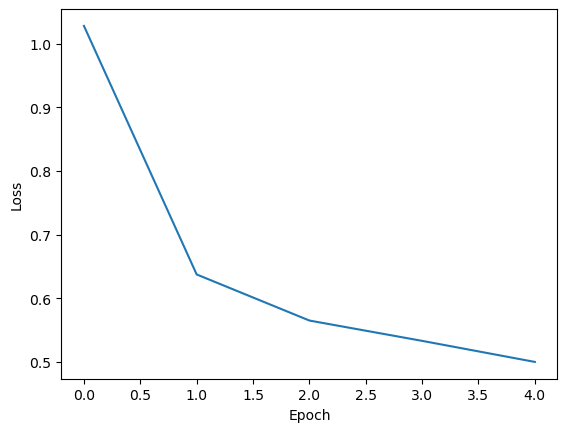

In [17]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history["loss"])

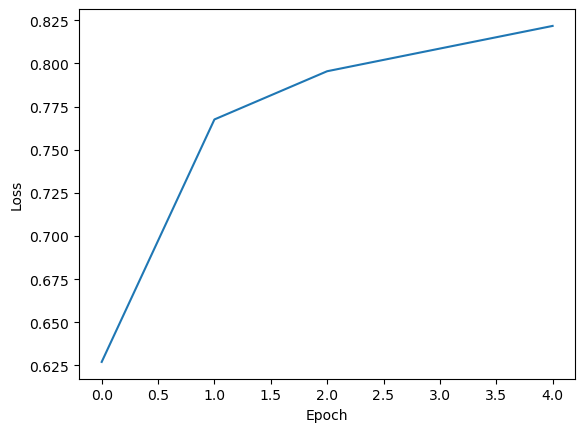

In [18]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history["accuracy"])

1/1 [==============================] - 0s 44ms/step


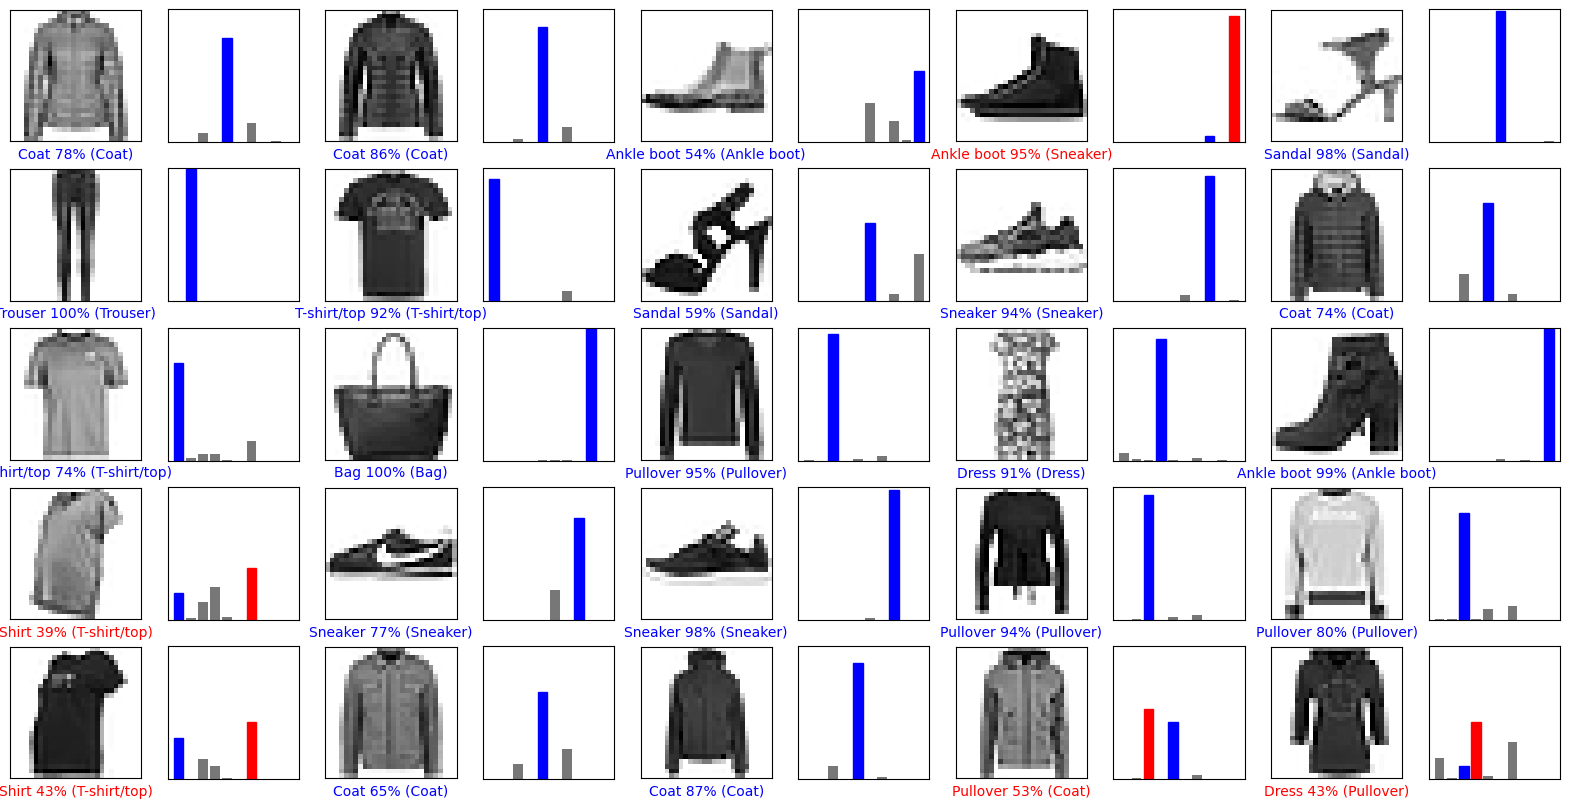

In [19]:
# Paint a grid with multiple predictions and mark them as correct (blue) or incorrect (red)
import numpy as np

for test_images, test_labels in test.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)
  
def plot_image(i, prediction_array, true_labels, images):
    prediction_array, true_label, img = prediction_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[...,0], cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(prediction_array),
                                class_names[true_label]),
                                color=color)
  
def plot_value_array(i, prediction_array, true_label):
    prediction_array, true_label = prediction_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    bar_plot = plt.bar(range(10), prediction_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(prediction_array)

    bar_plot[predicted_label].set_color('red')
    bar_plot[true_label].set_color('blue')
  
rows = 5
columns = 5
num_images = rows * columns
plt.figure(figsize=(2*2*columns, 2*rows))
for i in range(num_images):
    plt.subplot(rows, 2*columns, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(rows, 2*columns, 2*i+2)
    plot_value_array(i, predictions, test_labels)


In [20]:
model.fit(train, epochs=10, steps_per_epoch= math.ceil(train_count/batch_size))

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4798 - accuracy: 0.8290
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4584 - accuracy: 0.8375
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4471 - accuracy: 0.8398
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4285 - accuracy: 0.8470
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4214 - accuracy: 0.8502
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4125 - accuracy: 0.8512
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3982 - accuracy: 0.8597
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4010 - accuracy: 0.8562
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3931 - accuracy: 0.8600
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.383

In [ ]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

def paint_and_model():

    width = 200  # canvas width
    height = 200 # canvas height
    center = height//2
    white = (255, 255, 255) # canvas back

    def paint(event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        canvas.create_oval(x1, y1, x2, y2, fill="black",width=15)
        draw.line([x1, y1, x2, y2],fill="black",width=15)

    master = Tk()

    def close_window():
        master.destroy()
        
    def clear_window():
        canvas.delete("all")
        output_image.paste((255, 255, 255), (0, 0, width, height))        
    
    def do_classify():
        resized_image = output_image.resize((28, 28))
        # Convert the image to grayscale
        grayscale_image = resized_image.convert("L")

        # Convert the image to a NumPy array
        image_array = np.array(grayscale_image)

        normalized_image = image_array / 255.0
        predictions = model.predict(1 - normalized_image)
        print(np.round(predictions*100))

        # Get the predicted class index
        predicted_class_index = np.argmax(predictions)
        classification_label.config(text=f"{class_names[predicted_class_index]}")


    # create a tkinter canvas to draw on
    canvas = Canvas(master, width=width, height=height, bg='white')
    canvas.pack()

    # create an empty PIL image and draw object to draw on
    output_image = PIL.Image.new("RGB", (width, height), white)
    draw = ImageDraw.Draw(output_image)
    canvas.pack(expand=YES, fill=BOTH)
    canvas.bind("<B1-Motion>", paint)
    
    classification_label = Label(master, text="", font=("Courier Bold", 15))
    classification_label.pack()

    b1=Button(text="classify",command=do_classify)
    b1.pack(side=LEFT)
    
    button=Button(text="clear",command=clear_window)
    button.pack(side=LEFT)
        
    button=Button(text="close",command=close_window)
    button.pack(side=LEFT)
    
    master.mainloop()
    
paint_and_model()

1/1 [==============================] - 0s 37ms/step
[[  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.]]
1/1 [==============================] - 0s 12ms/step
[[  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]]
1/1 [==============================] - 0s 12ms/step
[[  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]]
1/1 [==============================] - 0s 12ms/step
[[  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]]
1/1 [==============================] - 0s 12ms/step
[[  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]]
1/1 [==============================] - 0s 13ms/step
[[ 0.  0.  0.  0.  0.  0.  1.  0. 99.  0.]]
1/1 [==============================] - 0s 12ms/step
[[ 4.  0.  3.  4.  1. 84.  3.  1.  1.  0.]]
1/1 [==============================] - 0s 12ms/step
[[99.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
1/1 [==============================] - 0s 12ms/step
[[  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]]
1/1 [==============================] - 0s 12ms/step
[[  0.   0.   0.   0.   

The problem here are that the pixel positions are features, so you cannot move the images, because the features are changed. For that, we need to deal with other type of network ... CNNs